In [ ]:
# Loading and Exploring The Data

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/sample_data/loan_approval_dataset.csv')

print(f"Dataset shape: {df.shape}")

# Clean column names
df.columns = df.columns.str.strip()

print(f"\nTarget distribution:\n{df['loan_status'].value_counts()}")
print(f"\nMissing values: {df.isnull().sum().sum()}")




Dataset shape: (4269, 13)

Target distribution:
loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64

Missing values: 0


In [ ]:
# Identify feature types
categorical_cols = ['education', 'self_employed']
numerical_cols = ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term',
                 'cibil_score', 'residential_assets_value', 'commercial_assets_value',
                 'luxury_assets_value', 'bank_asset_value']

print(f"\nCategorical features: {categorical_cols}")
print(f"Numerical features: {len(numerical_cols)} columns")

# Display first few rows
df.head()


Categorical features: ['education', 'self_employed']
Numerical features: 9 columns


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [ ]:
# Data Preprocessing and Cleaning

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

df_processed = df.copy()

# Encode categorical variables
le_education = LabelEncoder()
le_employed = LabelEncoder()
le_target = LabelEncoder()

df_processed['education'] = le_education.fit_transform(df_processed['education'])
df_processed['self_employed'] = le_employed.fit_transform(df_processed['self_employed'])
df_processed['loan_status_encoded'] = le_target.fit_transform(df_processed['loan_status'])

print("Categorical encoding completed:")
print(f"Education: {le_education.classes_} -> {le_education.transform(le_education.classes_)}")
print(f"Self-employed: {le_employed.classes_} -> {le_employed.transform(le_employed.classes_)}")
print(f"Target: {le_target.classes_} -> {le_target.transform(le_target.classes_)}")

print(f"\nProcessed dataset shape: {df_processed.shape}")

Categorical encoding completed:
Education: [' Graduate' ' Not Graduate'] -> [0 1]
Self-employed: [' No' ' Yes'] -> [0 1]
Target: [' Approved' ' Rejected'] -> [0 1]

Processed dataset shape: (4269, 14)


Outlier Analysis (IQR method):
income_annum: 0 outliers (0.0%)
loan_amount: 0 outliers (0.0%)
residential_assets_value: 52 outliers (1.2%)
commercial_assets_value: 37 outliers (0.9%)


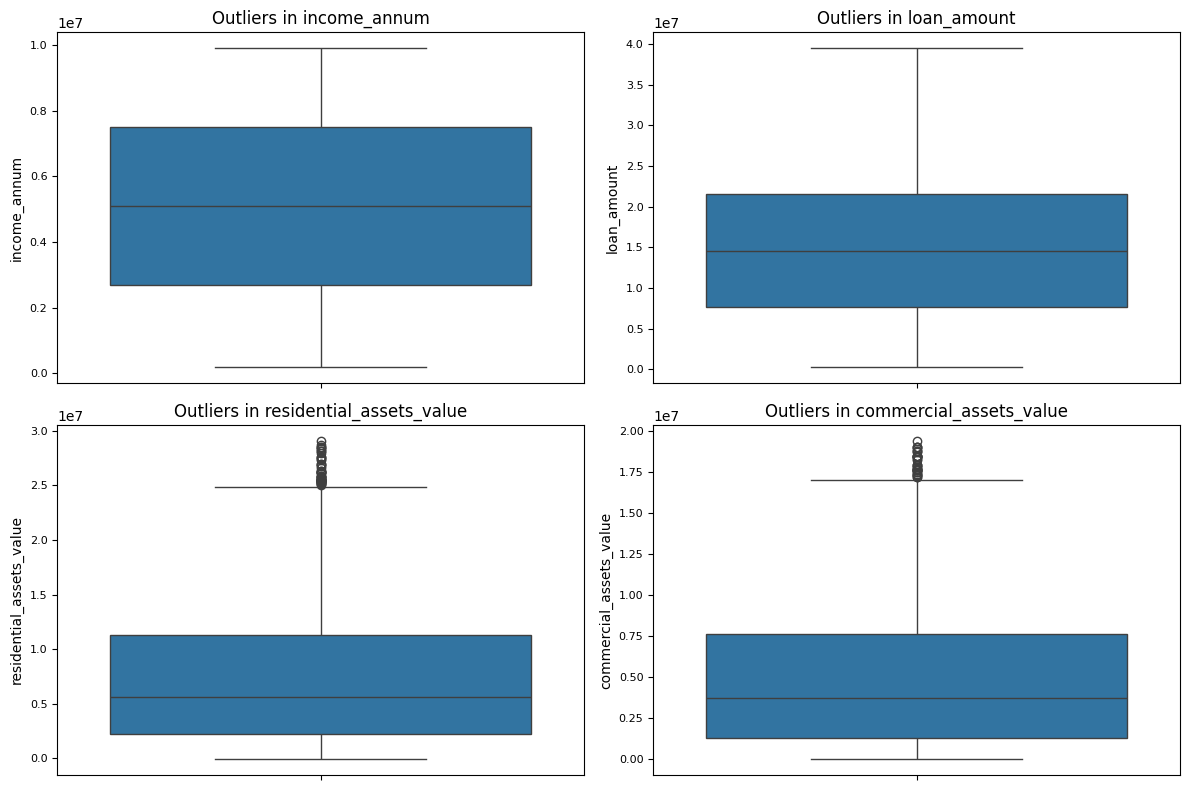

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def detect_outliers_iqr(data, column):
    Q1, Q3 = data[column].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower) | (data[column] > upper)]
    return len(outliers), (len(outliers) / len(data)) * 100

outlier_analysis = {}
key_cols = ['income_annum', 'loan_amount', 'residential_assets_value', 'commercial_assets_value']

print("Outlier Analysis (IQR method):")
for col in key_cols:
    count, percent = detect_outliers_iqr(df_processed, col)
    outlier_analysis[col] = {'count': count, 'percentage': percent}
    print(f"{col}: {count} outliers ({percent:.1f}%)")

# Visualization 1: Boxplots for outlier detection
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for i, col in enumerate(key_cols):
    sns.boxplot(data=df_processed, y=col, ax=axes[i])
    axes[i].set_title(f'Outliers in {col}')
    axes[i].tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()

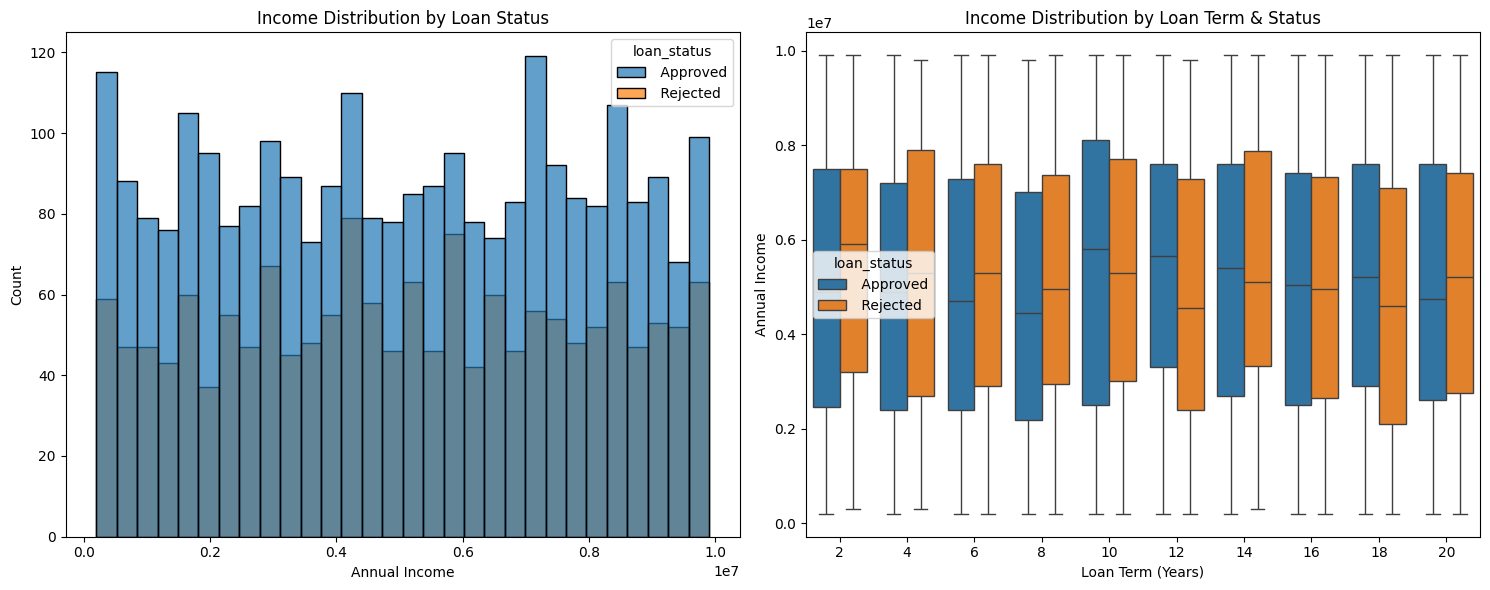

In [ ]:
# Visualization 2: Distribution Analysis and Feature Relationships
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Income Distribution by Loan Status
sns.histplot(data=df_processed, x='income_annum', hue='loan_status',
             bins=30, alpha=0.7, ax=axes[0])
axes[0].set_title('Income Distribution by Loan Status')
axes[0].set_xlabel('Annual Income')

# 2. Loan Term vs Income by Approval Status
sns.boxplot(data=df_processed, x='loan_term', y='income_annum',
            hue='loan_status', ax=axes[1])
axes[1].set_title('Income Distribution by Loan Term & Status')
axes[1].set_xlabel('Loan Term (Years)')
axes[1].set_ylabel('Annual Income')

plt.tight_layout()
plt.show()


In [ ]:
# Outlier Treatment Using Log Transformations and Capping Methods

Applying outlier treatment methods...
✓ Log transformation applied to 4 features
✓ Winsorization applied to 4 features


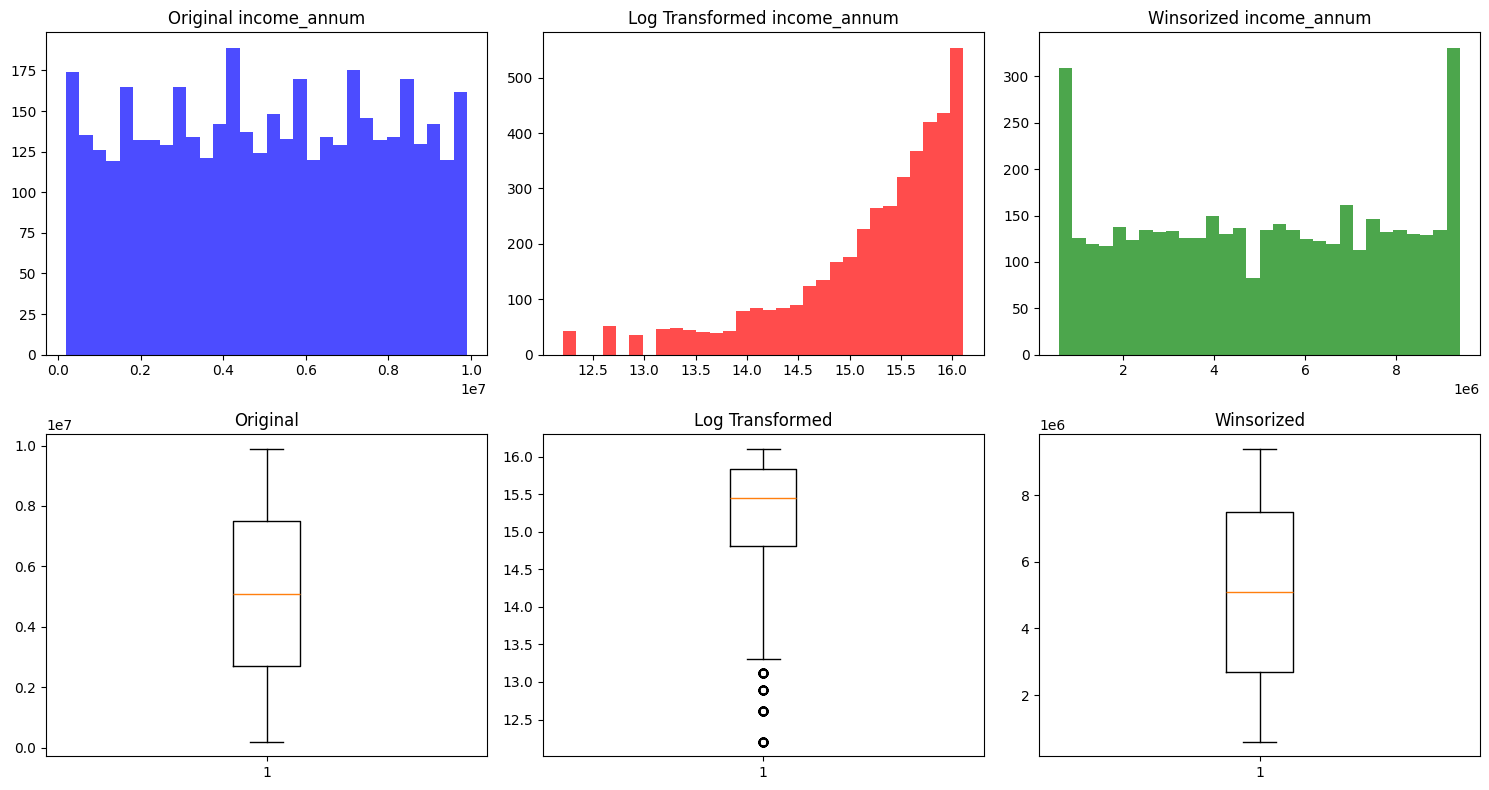

In [ ]:
import warnings

df_treated = df_processed.copy()

# Method 1: Log transformation for skewed features
log_cols = ['income_annum', 'loan_amount', 'residential_assets_value', 'commercial_assets_value']
print("Applying outlier treatment methods...")

for col in log_cols:
    df_treated[f'{col}_log'] = np.log(df_treated[col].abs() + 1)

# Method 2: Winsorization (cap at 5th and 95th percentiles)
for col in log_cols:
    lower, upper = df_treated[col].quantile([0.05, 0.95])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", FutureWarning)
        clipped_values = df_treated[col].clip(lower=lower, upper=upper)
    df_treated[f'{col}_winsorized'] = clipped_values.astype(df_treated[col].dtype)

print(f"✓ Log transformation applied to {len(log_cols)} features")
print(f"✓ Winsorization applied to {len(log_cols)} features")

# Compare distributions: Original vs Log-transformed vs Winsorized
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
sample_col = 'income_annum'

# Histograms
axes[0,0].hist(df_treated[sample_col], bins=30, alpha=0.7, color='blue')
axes[0,0].set_title(f'Original {sample_col}')

axes[0,1].hist(df_treated[f'{sample_col}_log'], bins=30, alpha=0.7, color='red')
axes[0,1].set_title(f'Log Transformed {sample_col}')

axes[0,2].hist(df_treated[f'{sample_col}_winsorized'], bins=30, alpha=0.7, color='green')
axes[0,2].set_title(f'Winsorized {sample_col}')

# Boxplots
axes[1,0].boxplot(df_treated[sample_col])
axes[1,0].set_title('Original')

axes[1,1].boxplot(df_treated[f'{sample_col}_log'])
axes[1,1].set_title('Log Transformed')

axes[1,2].boxplot(df_treated[f'{sample_col}_winsorized'])
axes[1,2].set_title('Winsorized')

plt.tight_layout()
plt.show()

In [ ]:
# Feature Interaction Creation

In [ ]:
df_features = df_treated.copy()


# 1. Income to Loan Ratio
df_features['income_to_loan_ratio'] = df_features['income_annum'] / (df_features['loan_amount'] + 1)

# 2. Loan to Income Ratio (Debt-to-Income)
df_features['loan_to_income_ratio'] = df_features['loan_amount'] / (df_features['income_annum'] + 1)

# 3. Total Assets
df_features['total_assets'] = (df_features['residential_assets_value'] +
                              df_features['commercial_assets_value'] +
                              df_features['luxury_assets_value'] +
                              df_features['bank_asset_value'])

# 4. Asset to Income Ratio
df_features['asset_to_income_ratio'] = df_features['total_assets'] / (df_features['income_annum'] + 1)

# 5. Income per Dependent
df_features['income_per_dependent'] = df_features['income_annum'] / (df_features['no_of_dependents'] + 1)

# 6. CIBIL Score Interaction with Income
df_features['cibil_income_interaction'] = df_features['cibil_score'] * df_features['income_annum'] / 1000000

# 7. High CIBIL Score (Binary Feature)
df_features['high_cibil'] = (df_features['cibil_score'] >= 750).astype(int)

interaction_features = ['income_to_loan_ratio', 'loan_to_income_ratio', 'total_assets',
                       'asset_to_income_ratio', 'income_per_dependent',
                       'cibil_income_interaction', 'high_cibil']

print(f"Created {len(interaction_features)} interaction features:")
for feature in interaction_features:
    print(f"  • {feature}")

Created 7 interaction features:
  • income_to_loan_ratio
  • loan_to_income_ratio
  • total_assets
  • asset_to_income_ratio
  • income_per_dependent
  • cibil_income_interaction
  • high_cibil


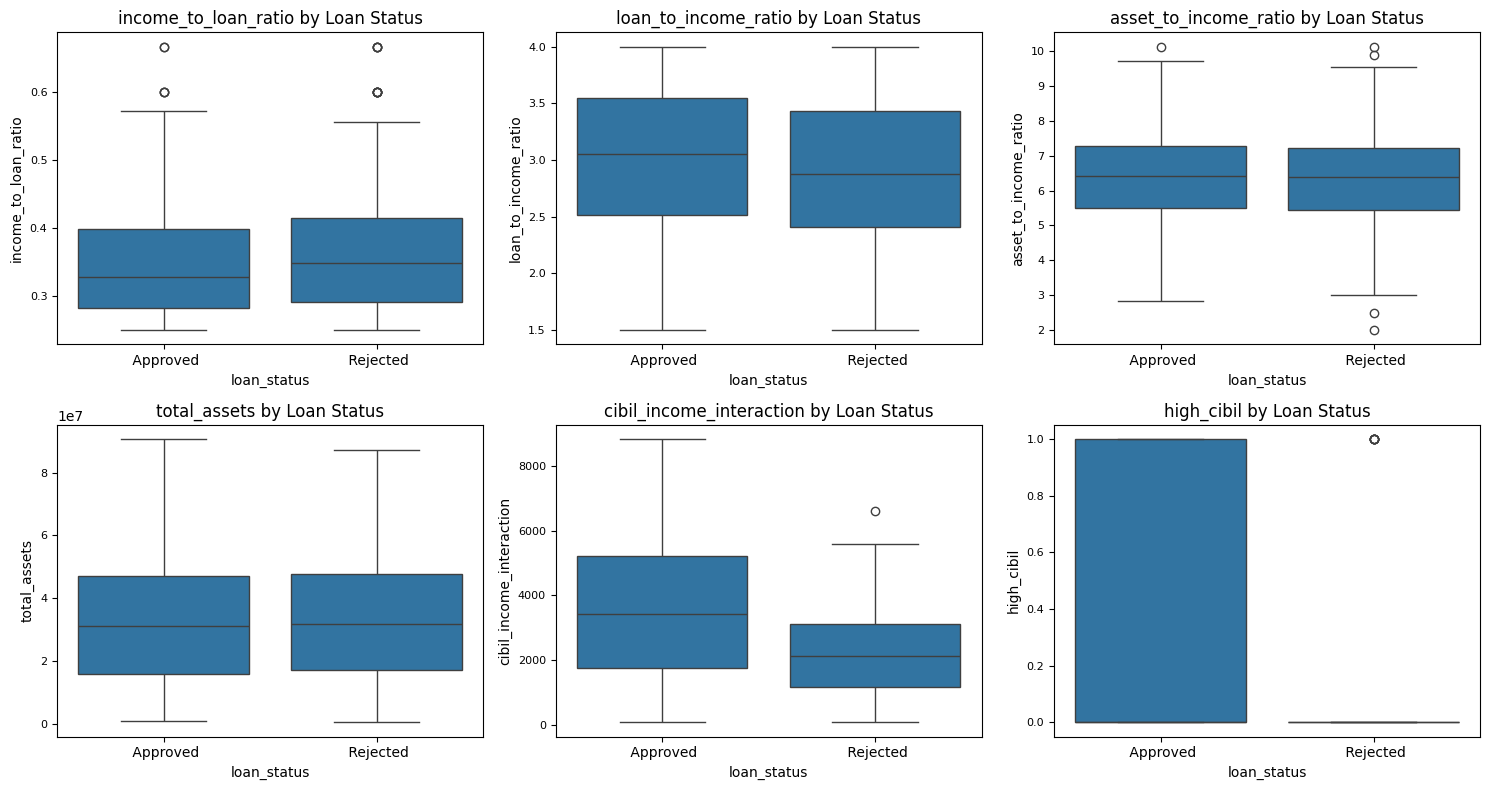

In [ ]:
# Visualize key interactions by loan status
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

key_interactions = ['income_to_loan_ratio', 'loan_to_income_ratio', 'asset_to_income_ratio',
                   'total_assets', 'cibil_income_interaction', 'high_cibil']

for i, feature in enumerate(key_interactions):
    sns.boxplot(data=df_features, x='loan_status', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature} by Loan Status')
    axes[i].tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()

In [ ]:
# Feature Scaling and Normalization

In [ ]:
feature_cols = (['no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount',
                'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value',
                'luxury_assets_value', 'bank_asset_value'] + interaction_features)

X = df_features[feature_cols]
y = df_features['loan_status_encoded']

X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median())

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Features to scale: {len(feature_cols)}")

scalers = {
    'Original': None,
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

Feature matrix shape: (4269, 18)
Target vector shape: (4269,)
Features to scale: 18


In [ ]:
# Train-Test Split and Model Training

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = []

print(f"Training {len(models)} models with {len(scalers)} scaling methods...")
print("=" * 60)

for scaler_name, scaler in scalers.items():
    print(f"\n=== {scaler_name} Scaling ===")

    if scaler is None:
        X_scaled = X
    else:
        X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        results.append({
            'Scaling': scaler_name,
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })

        print(f"{model_name}: Accuracy={accuracy:.3f}, F1={f1:.3f}")

print("\n" + "=" * 60)

Training 2 models with 4 scaling methods...

=== Original Scaling ===
Logistic Regression: Accuracy=0.905, F1=0.904
Random Forest: Accuracy=0.996, F1=0.996

=== StandardScaler Scaling ===
Logistic Regression: Accuracy=0.923, F1=0.922
Random Forest: Accuracy=0.996, F1=0.996

=== MinMaxScaler Scaling ===
Logistic Regression: Accuracy=0.919, F1=0.919
Random Forest: Accuracy=0.996, F1=0.996

=== RobustScaler Scaling ===
Logistic Regression: Accuracy=0.920, F1=0.920
Random Forest: Accuracy=0.996, F1=0.996



In [ ]:
# Create results summary
results_df = pd.DataFrame(results)

print("=" * 80)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 80)
print(results_df.round(4))

MODEL PERFORMANCE SUMMARY
          Scaling                Model  Accuracy  Precision  Recall  F1-Score
0        Original  Logistic Regression    0.9052     0.9052  0.9052    0.9043
1        Original        Random Forest    0.9965     0.9965  0.9965    0.9965
2  StandardScaler  Logistic Regression    0.9227     0.9226  0.9227    0.9223
3  StandardScaler        Random Forest    0.9965     0.9965  0.9965    0.9965
4    MinMaxScaler  Logistic Regression    0.9192     0.9192  0.9192    0.9187
5    MinMaxScaler        Random Forest    0.9965     0.9965  0.9965    0.9965
6    RobustScaler  Logistic Regression    0.9204     0.9203  0.9204    0.9199
7    RobustScaler        Random Forest    0.9965     0.9965  0.9965    0.9965


In [ ]:
# Find best performing model
best_idx = results_df['F1-Score'].idxmax()
best_result = results_df.loc[best_idx]

print(f"\n=== BEST PERFORMING MODEL ===")
print(f"Model: {best_result['Model']}")
print(f"Scaling Method: {best_result['Scaling']}")
print(f"F1-Score: {best_result['F1-Score']:.4f}")
print(f"Accuracy: {best_result['Accuracy']:.4f}")
print(f"Precision: {best_result['Precision']:.4f}")
print(f"Recall: {best_result['Recall']:.4f}")


=== BEST PERFORMING MODEL ===
Model: Random Forest
Scaling Method: Original
F1-Score: 0.9965
Accuracy: 0.9965
Precision: 0.9965
Recall: 0.9965


In [ ]:
# Feature Importance Analysis

=== FEATURE IMPORTANCE ANALYSIS ===


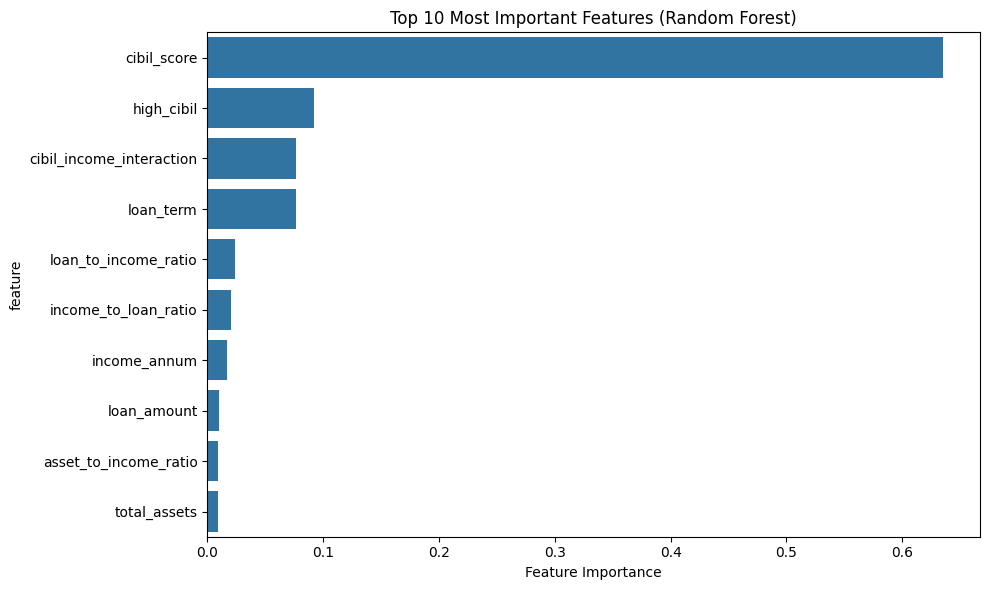

Top 10 Most Important Features:
                 feature  importance
             cibil_score    0.635467
              high_cibil    0.092269
cibil_income_interaction    0.076489
               loan_term    0.076437
    loan_to_income_ratio    0.023549
    income_to_loan_ratio    0.020499
            income_annum    0.016590
             loan_amount    0.009805
   asset_to_income_ratio    0.009203
            total_assets    0.009160


In [ ]:
print("=== FEATURE IMPORTANCE ANALYSIS ===")

best_scaler = scalers[best_result['Scaling']]
if best_scaler is None:
    X_final = X
else:
    X_final = pd.DataFrame(best_scaler.fit_transform(X), columns=X.columns)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_final, y)

importance_df = pd.DataFrame({
    'feature': X_final.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Visualize top 10 most important features
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features (Random Forest)')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))
